<a href="https://colab.research.google.com/github/halilyaman/atlas-machine-learning/blob/master/CE475_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Methods**

1.   Multiple Linear Regression
2.   Polynomial Regression
3.   K-Nearest Neighbors
4.   Neural Networks

#**EDA**

**Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import xlwt
from xlwt import Workbook

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Load the data**

In [2]:
PATH = "drive/My Drive/IEU/CE475_project/data.csv"
data = pd.read_csv(PATH)

data.head()

,SampleNo,x1,x2,x3,x4,x5,x6,Y
0,1,32,-11,32,8,-11,24,10376.0
1,2,27,-20,10,55,-20,44,2143.0
2,3,27,-18,18,14,-18,47,4450.0
3,4,32,13,22,71,13,16,-28.0
4,5,17,-9,23,15,-9,44,5277.0


**Get training and test data**

In [0]:
training = data[:100]
test = data[100:]

training_inputs_df = training[["x1", "x2", "x3", "x4", "x5", "x6"]]
training_outputs_df = training["Y"]
test_inputs_df = test[["x1", "x2", "x3", "x4", "x5", "x6"]]

# **Data Distribution**

In [4]:
data = data.drop(["SampleNo"], axis=1)
data.describe()

,x1,x2,x3,x4,x5,x6,Y
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,100.000000
mean,18.716667,0.941667,17.066667,48.266667,0.941667,24.883333,1859.750000
std,12.470593,11.644089,10.810618,27.596959,11.644089,14.683887,2717.641332
min,0.000000,-20.000000,0.000000,2.000000,-20.000000,1.000000,-43.000000
25%,8.000000,-9.000000,7.000000,22.750000,-9.000000,12.000000,0.000000
50%,18.500000,1.000000,17.500000,48.000000,1.000000,24.000000,753.500000
75%,29.000000,11.000000,26.500000,74.000000,11.000000,37.250000,2262.500000
max,40.000000,20.000000,35.000000,97.000000,20.000000,50.000000,12575.000000


**Plot the histogram of training output**

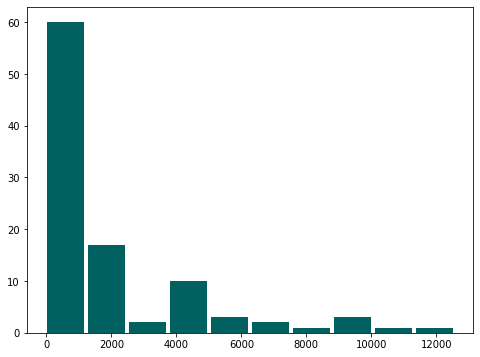

In [5]:
Y_train_hist = training_outputs_df.hist(
    figsize=(8, 6),
    grid=False,
    color='#016161',
    rwidth=0.9
)

**Plot the histogram of training input attributes**

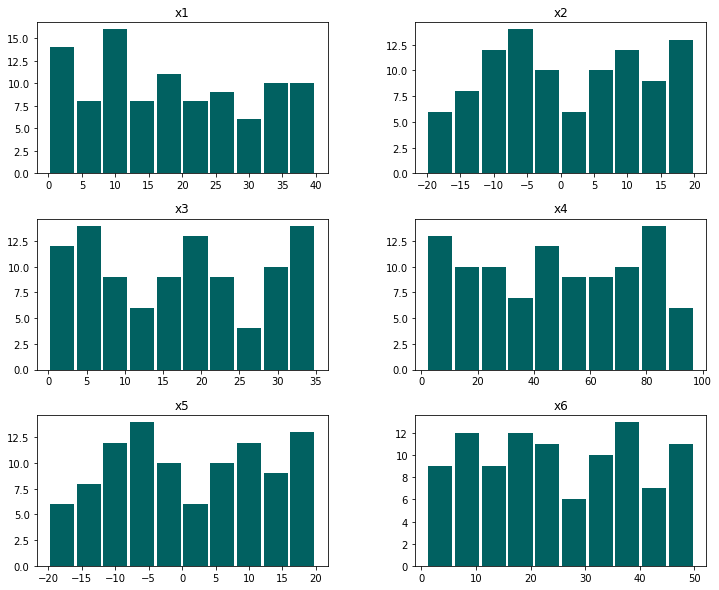

In [6]:
X_train_hist = training_inputs_df.hist(
    figsize=(12, 10),
    grid=False,
    color='#016161', 
    rwidth=0.9)

**Plot the histogram of test input attributes**

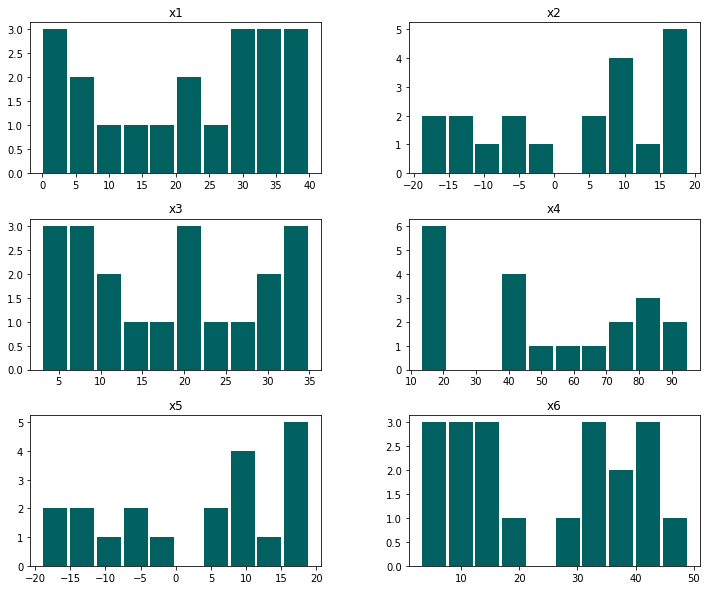

In [7]:
X_test_hist = test_inputs_df.hist(
    figsize=(12, 10),
    grid=False,
    color='#016161',
    rwidth=0.9)

**Plot the correlation matrix of training input variables**

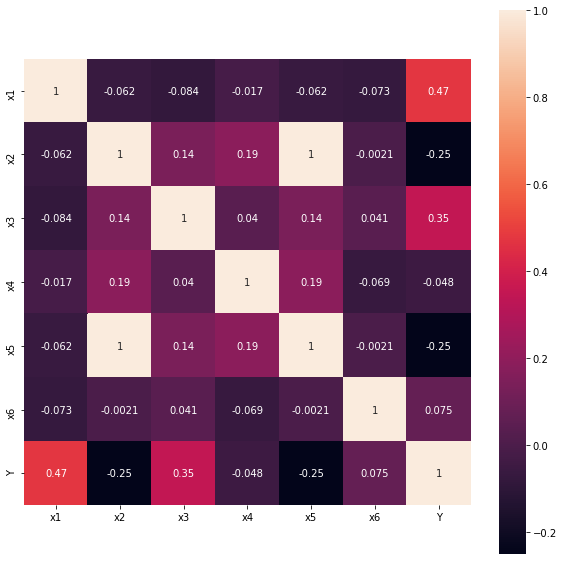

In [8]:
C_mat = data.corr()
fig = plt.figure(figsize=(10, 10))
sb.heatmap(C_mat, vmax=1.0, square=True, annot=True)

**Plot pairwise relationships in a dataset**

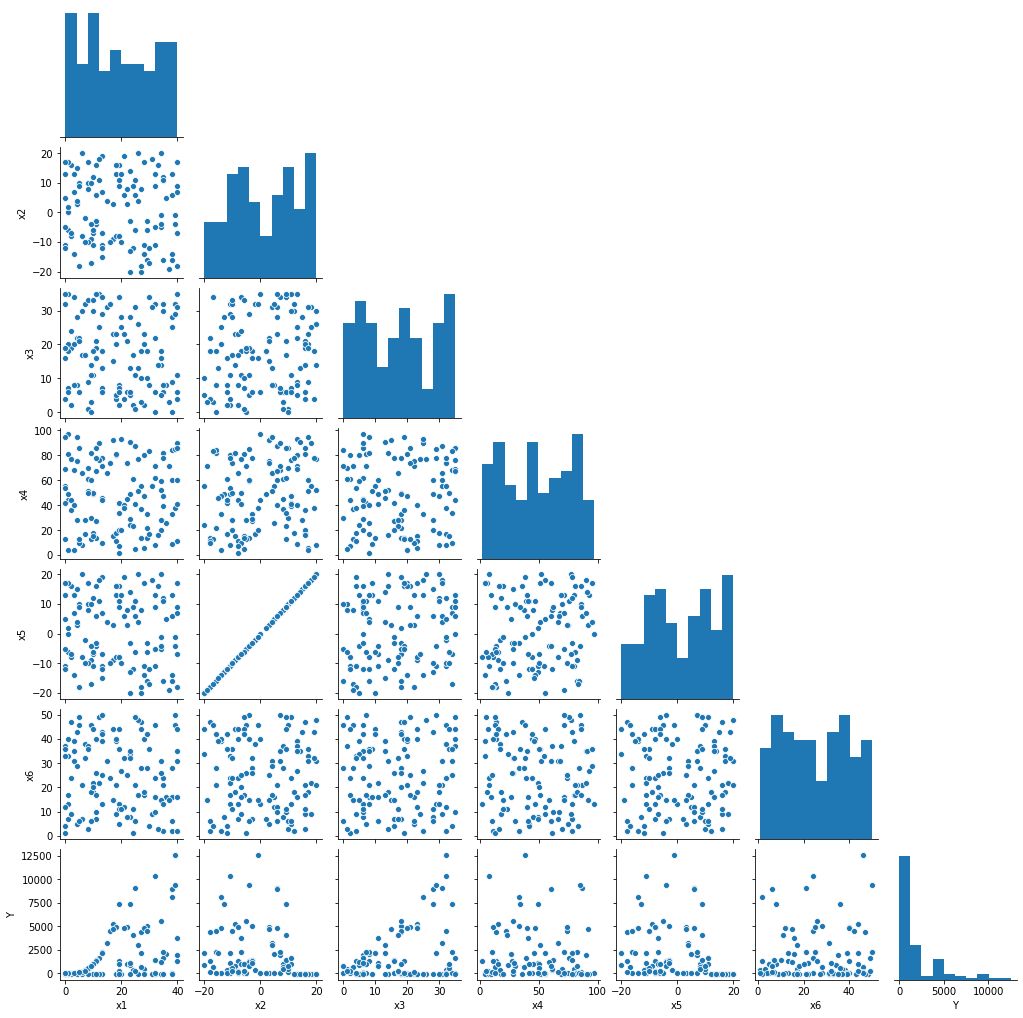

In [9]:
sb.pairplot(data, height=2, corner=True)

# **Interpretation of the Distribution**

**If we analyze the distributions, we see that x2 and x5 are exactly the same. So we can drop one of them.**

In [10]:
# drop the column "x5"
training_inputs_df = training_inputs_df.drop(["x5"], axis=1)
test_inputs_df = test_inputs_df.drop(["x5"], axis=1)

# convert data frames to numpy array
training_inputs = np.array(training_inputs_df)
training_outputs = np.array(training_outputs_df)
test_inputs = np.array(test_inputs_df)

# print the sizes
print("Training data size: {}".format(training_inputs.shape[0]))
print("Test data size: {}".format(test_inputs.shape[0]))

Training data size: 100
Test data size: 20


# **Helper Functions**

In [0]:
def get_r_square(y_pred, y):

  y_avg = np.mean(y)
  rss = np.sum(np.square(y - y_pred))
  tss = np.sum(np.square(y - y_avg))

  return 1 - (rss / tss)

In [0]:
def get_adj_rsquare(y_pred, y, p, n):

  return 1 - (1 - get_r_square(y_pred, y)) * ((n - 1)/(n - p - 1))

In [0]:
def get_rmse(y_pred, y):

  sse = np.sum(np.square(y - y_pred))
  mse = (1 / len(y)) * sse
  rmse = np.sqrt(mse)

  return rmse

In [0]:
def plot_result(pred_val, actual_val):

  """Plots the predictions vs actual output values."""

  pred_val = pred_val.flatten()
  actual_val = actual_val.flatten()

  plt.scatter(pred_val, actual_val)
  plt.xlabel("Predicted Values", fontsize=14)
  plt.ylabel("Actual Values", fontsize=14)
  plt.show()

  plot = sb.jointplot(pred_val, actual_val, kind="reg", color="blueviolet")
  plot.set_axis_labels("Predicted Values", "Actual Values", fontsize=14)

  plt.show()

In [0]:
def normalize_data(X, y):

  """Data normalization might improve the model accuracy"""

  scaler_X = MinMaxScaler()
  scaler_Y = MinMaxScaler()

  y = np.reshape(y, (-1, 1))

  scaler_X.fit(X)
  scaler_Y.fit(y)

  xscale = scaler_X.transform(X)
  yscale = scaler_Y.transform(y)

  return xscale, yscale, scaler_X, scaler_Y

In [0]:
def denormalize_data(data, scaler):

  """Inverse of the data normalization"""

  data = scaler.inverse_transform(data).T

  return data

In [0]:
def write_to_excel(data):

  wb = Workbook()

  sheet = wb.add_sheet("Prediction")

  for i, v in enumerate(data):
    
    sheet.write(i, 0, str(v))

  wb.save("submission.xls")

#**Recursive Feature Elimination Method With Linear Model**

In [18]:
# logging the R^2 values for number of attributes
log = dict()
adj_rsquared_values = []
linear_model = LinearRegression()

X = training_inputs
y = training_outputs

# iterate on attributes
for i in reversed(range(len(X.T))):
  
  kf = KFold(n_splits=4, random_state=None, shuffle=False)
  adj_rsquared_samples = []

  for train_index, test_index in kf.split(X):
    
    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rfe = RFE(linear_model, i+1)
    fit = rfe.fit(X_train, y_train)

    columns = []

    # Calculate the R^2 value
    adj_r_square = get_adj_rsquare(fit.predict(X_test), y_test, i+1, len(y_train))
    adj_rsquared_samples.append(adj_r_square)
  
  
  adj_rsquared_values.append(np.mean(adj_rsquared_samples))


  # save the selected columns
  for j, val in enumerate(fit.support_): 
    if val:
      columns.append(training_inputs_df.columns[j])
  
  
  log[i] = dict()
  log[i]["n_feature"] = i
  log[i]["selected_features"] = columns
  log[i]["adj_rsquared"] = np.mean(adj_rsquared_samples)

  print(f"Selected Features: {columns}")
  print(f"Adjusted R^2: {np.mean(adj_rsquared_samples)}")
  print("----------------------------------------------------------------")


best_adj_rsquared = np.max(adj_rsquared_values)

for i in range(len(log)):
  if log[i]["adj_rsquared"] == best_adj_rsquared:
    print("Best Score Features: "+str(log[i]["selected_features"]))
    print("Best Adjusted R^2: "+str(log[i]["adj_rsquared"]))
    

Selected Features: ['x1', 'x2', 'x3', 'x4', 'x6']
Adjusted R^2: 0.29703493542515635
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3', 'x4']
Adjusted R^2: 0.3282151046348831
----------------------------------------------------------------
Selected Features: ['x1', 'x2', 'x3']
Adjusted R^2: 0.3532079259779422
----------------------------------------------------------------
Selected Features: ['x1', 'x3']
Adjusted R^2: 0.2952015961329941
----------------------------------------------------------------
Selected Features: ['x1']
Adjusted R^2: 0.10095155450619864
----------------------------------------------------------------
Best Score Features: ['x1', 'x2', 'x3']
Best Adjusted R^2: 0.3532079259779422


# **L1 Regularization**

**This is another technique used for eliminating unimportant features**

In [0]:
def l1_regularization(X, y, alpha=2, n_splits=4):

  """
  This function is used for evaluating the lasso model.

  Parameters:
  X: input data
  y: output data
  alpha: constant that multiplies the L1 term
  alpha = 0 is equivalent to an ordinary least square
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """

  lasso = Lasso(alpha=alpha, normalize=True)
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit the training data to the model
    lasso.fit(X_train, y_train)

    # calculate R^2 value
    adj_rsquare = get_adj_rsquare(lasso.predict(X_test), y_test, 5, len(y_test))
    adj_rsquares.append(adj_rsquare)

    # get the prediction results
    predictions = np.append(predictions, lasso.predict(X_test))

  # calculate mean of r square values
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions, lasso.coef_

**Try the alpha values in range 1 to 30, and decide the best one based on R^2 value**

In [20]:
# find best alpha value for lasso
max_adj_rsquare = 0
best_alpha = 1

for i in range(1, 30):

  adj_rsquare, lasso_preds, _ = l1_regularization(training_inputs, training_outputs, alpha=i, n_splits=4)

  print("Alpha: {}   R^2: {}".format(i, adj_rsquare))

  if adj_rsquare > max_adj_rsquare:
    
    max_adj_rsquare = adj_rsquare
    best_alpha = i

Alpha: 1   R^2: 0.1744691655990636
Alpha: 2   R^2: 0.1770399554961985
Alpha: 3   R^2: 0.17952213070911988
Alpha: 4   R^2: 0.1818508606022458
Alpha: 5   R^2: 0.18402613796437237
Alpha: 6   R^2: 0.18580837451285573
Alpha: 7   R^2: 0.18738960477757435
Alpha: 8   R^2: 0.18883298383592567
Alpha: 9   R^2: 0.19013852344754262
Alpha: 10   R^2: 0.19119442042014154
Alpha: 11   R^2: 0.192095756713539
Alpha: 12   R^2: 0.19288178003350256
Alpha: 13   R^2: 0.19355249038003144
Alpha: 14   R^2: 0.19410788775312646
Alpha: 15   R^2: 0.1945479721527873
Alpha: 16   R^2: 0.19487274357901416
Alpha: 17   R^2: 0.19511797826191632
Alpha: 18   R^2: 0.19525466317237752
Alpha: 19   R^2: 0.1952800598450828
Alpha: 20   R^2: 0.19480352653523272
Alpha: 21   R^2: 0.19403142442467852
Alpha: 22   R^2: 0.19315547180454892
Alpha: 23   R^2: 0.19217566867484356
Alpha: 24   R^2: 0.19109201503556275
Alpha: 25   R^2: 0.18990451088670632
Alpha: 26   R^2: 0.18861315622827435
Alpha: 27   R^2: 0.1872179510602669
Alpha: 28   R^2: 0

In [21]:
# apply lasso with the best alpha value
adj_rsquare, lasso_preds, lasso_coef = l1_regularization(training_inputs, training_outputs, alpha=best_alpha, n_splits=4)

print("Alpha value: {}\nAdjusted R^2: {}".format(best_alpha, adj_rsquare))
print("Coefficients: {}".format(lasso_coef))

Alpha value: 19
Adjusted R^2: 0.1952800598450828
Coefficients: [107.22088359 -63.39467195 106.35340346  -0.           0.        ]


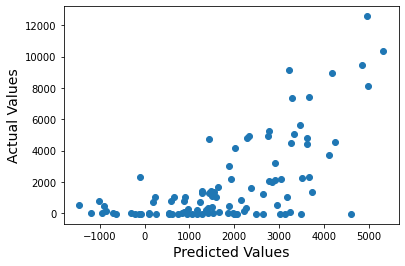

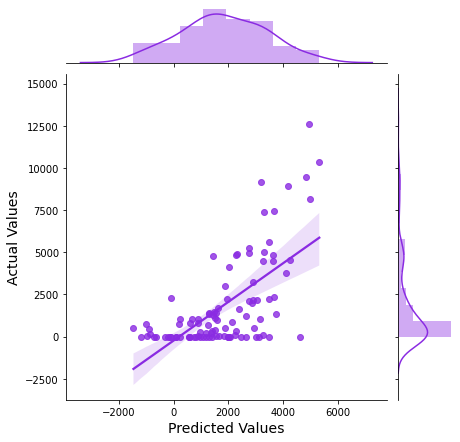

In [22]:
plot_result(lasso_preds, training_outputs)

**Remove the attributes x4 and x6**

In [0]:
training_inputs = training_inputs[:, 0:3]
test_inputs = test_inputs[:, 0:3]

# **1. Multiple Linear Regression**

In [0]:
def multi_lin_reg(X, y, n_splits=10):

  """
  This function is used for evaluating a multiple linear regression model.

  Parameters:
  X: input data
  y: output data
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """

  linear_model = LinearRegression()
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
  
  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):
    
    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # fit the training data to the model
    linear_model.fit(X_train, y_train)

    # calculate adjusted R^2 value
    adj_rsquare = get_adj_rsquare(
        linear_model.predict(X_test),
        y_test,
        p=3, n=100)
    adj_rsquares.append(adj_rsquare)

    # get the prediction results
    predictions = np.append(predictions, linear_model.predict(X_test))

  # calculate mean of r square values of each fold
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions

In [25]:
# apply multiple linear regression and get the R^2 value
adj_rsquare, MLR_preds = multi_lin_reg(training_inputs, training_outputs, n_splits=4)
print("Cross Validation R^2 adjusted: {}".format(adj_rsquare))

MLR_rmse = get_rmse(MLR_preds, training_outputs)
print("RMSE: {}".format(MLR_rmse))

Cross Validation R^2 adjusted: 0.3600363895972628
RMSE: 2018.1420078440972


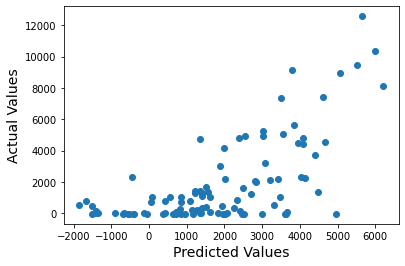

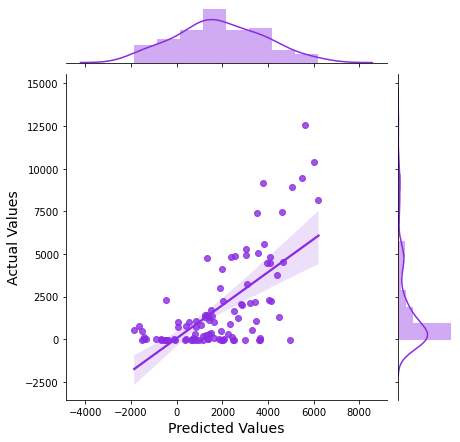

In [26]:
# plot the results
plot_result(MLR_preds, training_outputs)

# **2. Polynomial Regression**
**Since the data doesn't fit well enough the linear model, polynomial model might be a better approach.**

In [0]:
def poly_reg(X, y, degree=2, n_splits=5):

  """
  This function is used for evaluating the polynomial model.

  Parameters:
  X: input data
  y: output data
  degree: degree of the polynomial features
  n_splits: number of folds, used for cross validation

  Returns:
  r_square: R^2 value for evaluating the model performance
  predictions: predicted results
  """
  
  poly_features = PolynomialFeatures(degree=degree)

  X = poly_features.fit_transform(X)
  polynomial_model = LinearRegression()

  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  adj_rsquares = []
  predictions = np.array([])

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  
    polynomial_model.fit(X_train, y_train)

    # calculate adjusted R^2 value
    adj_rsquare = get_adj_rsquare(
        polynomial_model.predict(X_test),
        y_test,
        p=3, n=100)
    adj_rsquares.append(adj_rsquare)

    # get the predictions
    predictions = np.append(predictions, polynomial_model.predict(X_test))

  # calculate mean of r square values
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions


In [28]:
adj_rsquare, poly_preds = poly_reg(training_inputs, training_outputs, degree=2, n_splits=4)
print("Cross validation R^2 adjusted: {}".format(adj_rsquare))

poly_rmse = get_rmse(poly_preds, training_outputs)
print("RMSE: {}".format(poly_rmse))

Cross validation R^2 adjusted: 0.6356181902951482
RMSE: 1411.013552357784


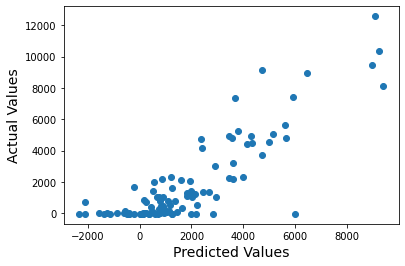

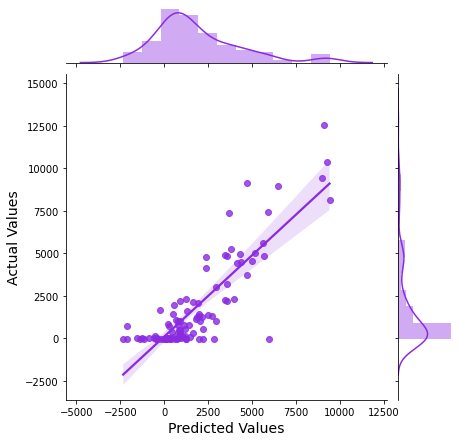

In [29]:
plot_result(poly_preds, training_outputs)

# **3. K-Nearest Neighbors**

In [0]:
def knn_reg(X, y, algorithm="auto", k=5, n_splits=5):

  """
  This function is used for evaluating the knn model.

  Parameters:
  X: input data
  y: output data
  algorithm: algorithm used to compute the nearest neighbors
  k: number of neighbors
  n_splits: number of folds, used for cross validation

  Returns:
  adj_rsquare: Adjusted R^2 value for evaluating the model performance
  predictions: predicted results
  """
  
  knn = KNeighborsRegressor(n_neighbors=k, algorithm=algorithm, weights="distance")

  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)

  adj_rsquares = []
  predictions = np.array([])
  rmse_values = []

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
  
    knn.fit(X_train, y_train)

    # calculate adjusted R^2 value
    adj_rsquare = get_adj_rsquare(
        knn.predict(X_test),
        y_test,
        p=3, n=100)
    adj_rsquares.append(adj_rsquare)

    # get the predictions
    predictions = np.append(predictions, knn.predict(X_test))

  # mean of adjusted r square values
  adj_rsquare = np.mean(adj_rsquares)

  return adj_rsquare, predictions

**Select the best k value based on RMSE**

In [31]:
best_k = 0
best_rmse = 99999

xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

X = xscale
y = yscale

for i in range(1, 20):

  rmse_values = []
  kf = KFold(n_splits=10, random_state=None, shuffle=False)

  for train_index, test_index in kf.split(X):

    # split data for training and testing
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    knn_model = KNeighborsRegressor(n_neighbors=i, algorithm="brute", weights="distance")
    knn_model.fit(X_train, y_train)
    preds = knn_model.predict(X_test)

    preds = np.reshape(preds, (-1, 1))
    preds = denormalize_data(preds, scaler_Y)

    knn_rmse = get_rmse(preds, training_outputs[test_index])
    rmse_values.append(knn_rmse)

  rmse_mean = np.mean(rmse_values)
  print("k: {}   RMSE: {}".format(i, rmse_mean))

  if rmse_mean < best_rmse:

    best_rmse = rmse_mean
    best_k = i

k: 1   RMSE: 1450.0690351436556
k: 2   RMSE: 1120.9429581748275
k: 3   RMSE: 1098.0978842397287
k: 4   RMSE: 1080.772686864379
k: 5   RMSE: 1128.4609577539331
k: 6   RMSE: 1223.634617307975
k: 7   RMSE: 1252.605658710656
k: 8   RMSE: 1329.983684020493
k: 9   RMSE: 1370.4167740774133
k: 10   RMSE: 1418.3232961514182
k: 11   RMSE: 1455.5192803048556
k: 12   RMSE: 1457.754489964334
k: 13   RMSE: 1496.7943892386966
k: 14   RMSE: 1510.1361493306788
k: 15   RMSE: 1524.9173728903554
k: 16   RMSE: 1548.7147464909958
k: 17   RMSE: 1576.8603038851998
k: 18   RMSE: 1589.5117349355678
k: 19   RMSE: 1605.571685376551


In [32]:
xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

adj_rsquare, knn_preds = knn_reg(
      xscale, 
      yscale,
      algorithm="brute", 
      k=best_k,
      n_splits=4)

knn_preds = np.reshape(knn_preds, (-1, 1))
knn_preds = denormalize_data(knn_preds, scaler_Y)

knn_rmse = get_rmse(knn_preds, training_outputs)

print("k: {}\nRMSE: {}\nAdj. R^2: {}".format(best_k, knn_rmse, adj_rsquare))

k: 4
RMSE: 1219.9762070256954
Adj. R^2: 0.7517702584327691


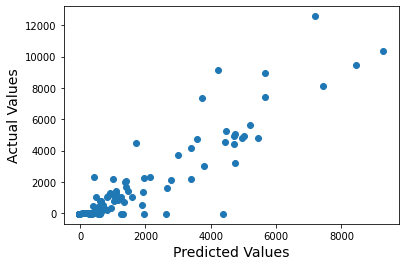

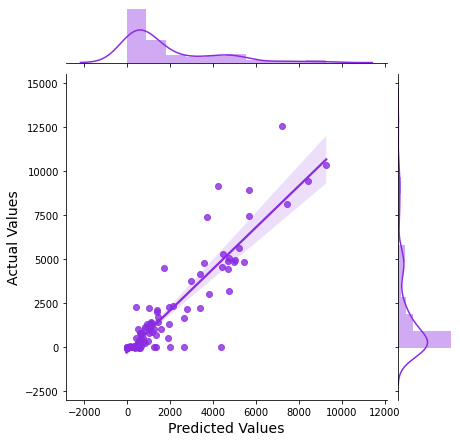

In [33]:
plot_result(knn_preds, training_outputs)

# **4. Neural Networks**

In [0]:
def build_model(input_dim, h1_units, h2_units):

  """
  Neural network model and layers are created in this function.

  Returns:
  NN_model: neural network model that we built
  """

  NN_model = tf.keras.Sequential()

  NN_model.add(tf.keras.layers.Dense(h1_units, input_dim=input_dim, kernel_initializer="normal", activation="relu"))
  NN_model.add(tf.keras.layers.Dense(h2_units, kernel_initializer="normal", activation="relu"))
  NN_model.add(tf.keras.layers.Dense(1, kernel_initializer="normal", activation="linear"))

  NN_model.compile(
      optimizer=tf.keras.optimizers.Adam(), 
      loss="mse",
      metrics=[tf.keras.metrics.RootMeanSquaredError()]
  )

  return NN_model

**Hidden units test**

In [0]:
h1_units = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 25, 30, 40, 50]
h2_units = [5, 6, 7, 8, 9, 10, 20, 30, 40]

rmse_values = np.zeros((17, 9))

print("Hidden\nUnits\nIn First\nLayer", end="")
print("             Hiddend Units in Second Layer        ")
print("        ---------------------------------------------------")
print("              5           6           7           8           9           10          20          30         40")


for row, h1_unit in enumerate(h1_units):

  print(" {}         ".format(h1_unit), end="")
  for col, h2_unit in enumerate(h2_units):
    
    # get the model
    NN_model = build_model(3, h1_unit, h2_unit)

    # normalize the training data
    xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

    # fitting data to the model
    history = NN_model.fit(
            training_inputs,
            training_outputs,
            epochs=300,
            batch_size=32,
            validation_split=0.25,
            verbose=0)
    
    rmse_values[row][col] = np.min(history.history["val_root_mean_squared_error"])
    print("{:.2f}     ".format(np.min(history.history["val_root_mean_squared_error"])), end="")
  
  print("")

print("\n\n")
print(rmse_values)

In [0]:
# get the model
NN_model = build_model(input_dim=3, h1_units=50, h2_units=40)

# normalize the training data
xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

# fitting data to the model
history = NN_model.fit(
    xscale,
    yscale,
    epochs=500,
    batch_size=100,
    validation_split=0.25,
    verbose=0)

**Loss values for both training and validation data**

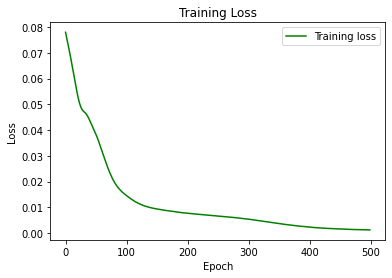

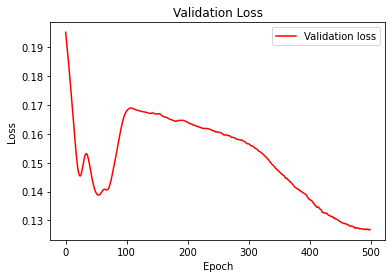

In [37]:
loss = history.history["loss"]
val_loss = history.history["val_root_mean_squared_error"]

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, "g", label="Training loss")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()

In [38]:
NN_preds = NN_model.predict(xscale)
NN_preds = scaler_Y.inverse_transform(NN_preds).T

adj_rsquare = get_adj_rsquare(NN_preds, training_outputs, p=3, n=100)
print("Adjusted R^2: {}".format(adj_rsquare))

NN_rmse = get_rmse(NN_preds, training_outputs)
print("RMSE: {}".format(NN_rmse))

Adjusted R^2: 0.8894819455896216
RMSE: 885.2060449905985


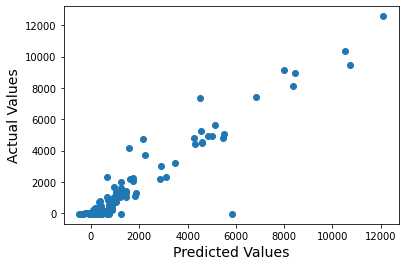

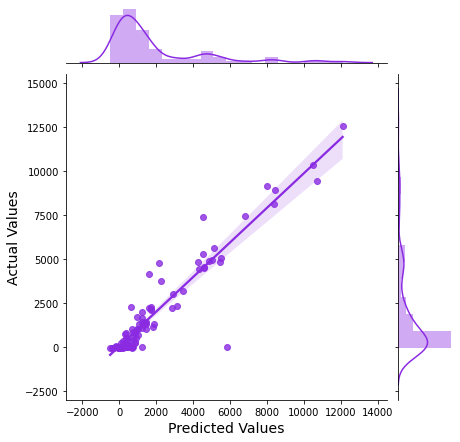

In [39]:
plot_result(NN_preds, training_outputs)

# **Plot The Results Of All Techniques**

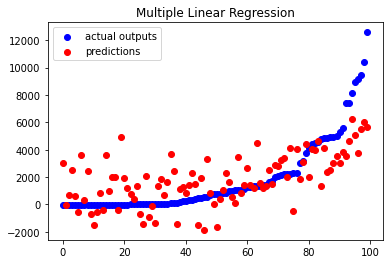

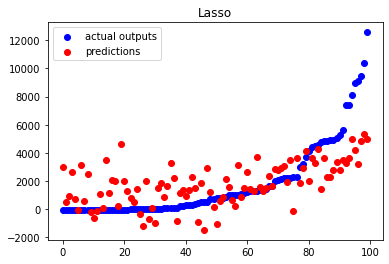

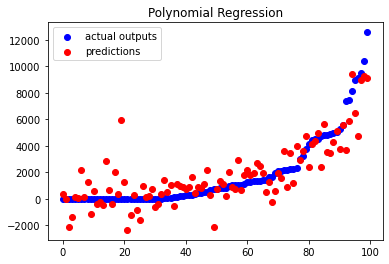

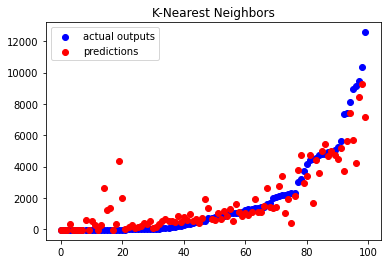

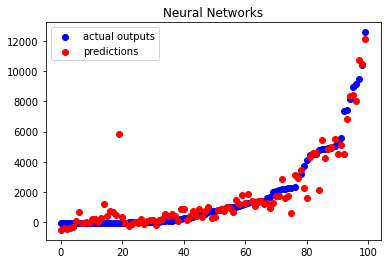

In [40]:
y = np.reshape(training_outputs, (-1, 1))

y_hat = np.reshape(MLR_preds, (-1, 1))

outputs = np.vstack([training_outputs, MLR_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Multiple Linear Regression")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(lasso_preds, (-1, 1))

outputs = np.vstack([training_outputs, lasso_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Lasso")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(poly_preds, (-1, 1))

outputs = np.vstack([training_outputs, poly_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Polynomial Regression")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(knn_preds, (-1, 1))

outputs = np.vstack([training_outputs, knn_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("K-Nearest Neighbors")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

y_hat = np.reshape(NN_preds, (-1, 1))

outputs = np.vstack([training_outputs, NN_preds]).T
outputs = outputs[outputs[:, 0].argsort()]

plt.figure()
plt.title("Neural Networks")
plt.scatter(range(len(outputs.T[0])), outputs.T[0], color="b", label="actual outputs")
plt.scatter(range(len(outputs.T[1])), outputs.T[1], color="r", label="predictions")
plt.legend()

# **Use All Methods On Test Data**


**Test Predictions: Linear Regression**

In [41]:
linear_model = LinearRegression()
linear_model.fit(training_inputs, training_outputs)

test_linear_preds = linear_model.predict(test_inputs).reshape(-1, 1)
np.set_printoptions(suppress=True)
print(test_linear_preds)

[[ 4930.47627065]
 [ 1265.2152527 ]
 [ 3710.96849573]
 [ 2770.57853453]
 [-1055.6540317 ]
 [ -558.31294634]
 [  848.35994147]
 [ 4639.1743268 ]
 [ 5939.05862377]
 [ 4085.37407508]
 [ 1155.47493802]
 [ 2206.63017126]
 [ 3062.45453119]
 [ 2762.48812769]
 [ 3773.01724963]
 [ 6424.12022307]
 [-1126.92129572]
 [ 1318.38104275]
 [-1783.86121337]
 [  232.04613514]]


**Test Predictions: Polynomial Regression**

In [42]:
poly_features = PolynomialFeatures(degree=2)

X = poly_features.fit_transform(training_inputs)
polynomial_model = LinearRegression()
polynomial_model.fit(X, training_outputs)

X_test = poly_features.fit_transform(test_inputs)
test_poly_preds = polynomial_model.predict(X_test).reshape(-1, 1)
np.set_printoptions(suppress=True)
print(test_poly_preds)

[[ 3656.4531087 ]
 [ 1234.62917931]
 [ 4748.34879245]
 [ 3191.26588294]
 [ 1217.24325212]
 [-1249.22876038]
 [  441.57625061]
 [ 5204.07796743]
 [ 7822.23855129]
 [ 5225.69219885]
 [  788.59389133]
 [  294.22996895]
 [ 2689.85914313]
 [ 2244.72214058]
 [ 1170.6443533 ]
 [ 9525.40374714]
 [ -522.76557873]
 [  309.11898958]
 [  853.59331699]
 [  888.1465355 ]]


**Test Predictions: KNN**

In [43]:
xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

knn = KNeighborsRegressor(n_neighbors=4, algorithm="brute", weights="distance")
knn.fit(xscale, yscale)

xtestscale = scaler_X.transform(test_inputs)
test_knn_preds = knn.predict(xtestscale).reshape(-1, 1)

test_knn_preds = scaler_Y.inverse_transform(test_knn_preds)
np.set_printoptions(suppress=True)
print(test_knn_preds)

[[1848.45321239]
 [1722.33946885]
 [4689.22185328]
 [2093.64478649]
 [ 564.75440344]
 [ 135.26519699]
 [ 864.3376482 ]
 [1798.21220901]
 [5112.07397798]
 [5738.38338182]
 [ -33.94045398]
 [ -31.85768139]
 [1359.09327306]
 [1383.9821874 ]
 [1057.16643053]
 [8233.74982639]
 [ -32.97502417]
 [ 118.10289871]
 [ 207.18340559]
 [   3.94126068]]


**Test Predictions: Neural Networks**

In [44]:
xscale, yscale, scaler_X, scaler_Y = normalize_data(training_inputs, training_outputs)

NN_model = build_model(input_dim=3, h1_units=50, h2_units=40)

history = NN_model.fit(
    xscale,
    yscale,
    epochs=200,
    batch_size=32,
    validation_split=0.0,
    verbose=0)

xtestscale = scaler_X.transform(test_inputs)
test_nn_preds = NN_model.predict(xtestscale)

test_nn_preds = scaler_Y.inverse_transform(test_nn_preds)
np.set_printoptions(suppress=True)
print(test_nn_preds)

[[ 5550.0947 ]
 [ 1014.00885]
 [ 4601.3887 ]
 [ 2514.0369 ]
 [  534.9563 ]
 [  334.1877 ]
 [ 1074.4504 ]
 [ 5801.641  ]
 [ 8534.395  ]
 [ 6127.0703 ]
 [  573.3435 ]
 [ 1467.2443 ]
 [ 1929.7295 ]
 [  924.5365 ]
 [  783.42206]
 [10088.97   ]
 [    3.3458 ]
 [ -205.26631]
 [  284.9504 ]
 [  220.26062]]


**Distributions Of Predictions On Test Data**

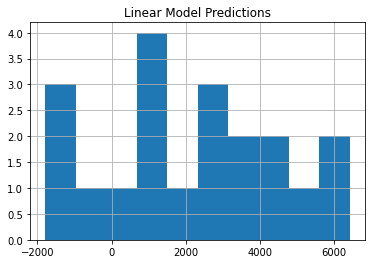

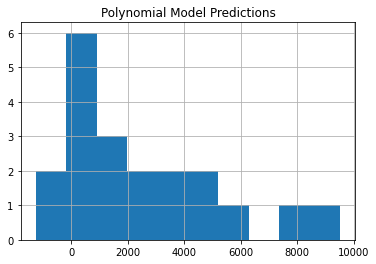

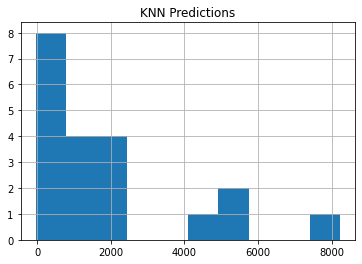

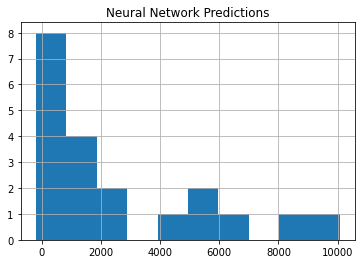

In [45]:
pd.DataFrame(test_linear_preds).hist()
t1 = plt.title("Linear Model Predictions")

pd.DataFrame(test_poly_preds).hist()
t2 = plt.title("Polynomial Model Predictions")

pd.DataFrame(test_knn_preds).hist()
t1 = plt.title("KNN Predictions")

pd.DataFrame(test_nn_preds).hist()
t2 = plt.title("Neural Network Predictions")

# **Submission**

**Based on R^2 values, I decided to use neural network architecture to submit my project.**

In [47]:
# normalize the test data
test_scaled = scaler_X.transform(test_inputs)

# get the predictions
preds = NN_model.predict(test_scaled)

# denormalize and print the predictions
submission = denormalize_data(preds, scaler_Y).T.astype("int")
print("These predictions can be a little bit different from submitted"
      " predictions because I tried many times.")
print(submission)

These predictions can be a little bit different from submitted predictions because I tried many times.
[[ 5550]
 [ 1014]
 [ 4601]
 [ 2514]
 [  534]
 [  334]
 [ 1074]
 [ 5801]
 [ 8534]
 [ 6127]
 [  573]
 [ 1467]
 [ 1929]
 [  924]
 [  783]
 [10088]
 [    3]
 [ -205]
 [  284]
 [  220]]


In [0]:
# save the test predictions to an excel file
write_to_excel(submission.T[0])